# An Initial Study about the Impact of Planned Construction on School Test Reports

## Data Sources:

- [NYC Test Results](http://schools.nyc.gov/Accountability/data/default.htm)
- [NYC School Point Locations](https://data.cityofnewyork.us/Education/School-Point-Locations/jfju-ynrr)
- [NYC Multi Agency Permits](https://data.cityofnewyork.us/City-Government/Multi-Agency-Permits/xfyi-uyt5)

## Test Results:

This data contains test results for all NYC schools, and it is strutured as the following:

| School Name | Grade | Year | Number Tested | Mean Scale Score | # | % | # | % | # | % | 

## Strategy

For each school with coordinates P, filter the scheduled constructions given a certain radius from P. Given that the **NYC Test Results** contains one test per year, it is also necessary to filter the permits given an specified period of time, say, 2/3 of a year.

# Code

### Imports 

In [1]:
# Imports 

%matplotlib inline

import csv, json
import time
import matplotlib
import matplotlib.pyplot as plt
import shapefile
import itertools
import numpy

from scipy.spatial import cKDTree
from scipy import inf
from sklearn import preprocessing
from sklearn import linear_model
# from geopy.geocoders import Nominatim
# from geopy.geocoders import GoogleV3
from geoindex import GeoGridIndex, GeoPoint
from shapely.geometry import shape, Point
# from rtree import index
from datetime import datetime, date, timedelta
# from haversine import haversine

### Pre-processing

In [2]:
# Opening the required data

shp = open("../Resources/Public_Schools_Points.shp", "rb")
dbf = open("../Resources/Public_Schools_Points.dbf", "rb")
sf = shapefile.Reader(shp=shp, dbf=dbf)

print "Number of schools in shape file:", len(list(sf.iterShapes()))

Number of schools in shape file: 1709


In [3]:
# Data Pre-Processing

# Creating a dictionary of school name : school point
school_points = {}

school_loc = csv.reader(open("../Resources/School_locations.csv", "rb"), delimiter=',')
for line in school_loc:
    school_points[line[0]] = (line[1], line[2])
    
# geolocator = Nominatim()
# geolocator = GoogleV3()
# records = sf.records()

# with open('../Resources/School_locations.csv', 'wb') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',')
#     for i, shape in enumerate(sf.shapes()):
#         adress = records[i][9] +' '+ sf.records()[i][16] +' '+ str(sf.records()[i][11])
#         location = geolocator.geocode(adress, timeout=100)
#         school_points[sf.records()[i][4]] = (location.latitude, location.longitude)
#         spamwriter.writerow([sf.records()[i][4], location.latitude, location.longitude])

In [4]:
# Returns a dictionary of permit type and info
def get_permiters_data(days_span):
    """
    Process the permiters .csv file
    :param days_span: number of days to be considered to count a permit issue
    :return: dictionary {permit : [lon, lat, ini, end]}
    """
    permiters = csv.DictReader(open("../Resources/Permiters.csv", "rb"), delimiter=',')
    permiters_data = {}
    for line in permiters:
        lon = line["Longitude_WGS84"]
        lat = line["Latitude_WGS84"]
        ini = datetime.strptime(line["Permit_Issuance_Date"], '%m/%d/%y 0:00')
        cat = line["Permit_Type_Description"]
        end = datetime.strptime(line["Permit_Expiration_Date"], '%m/%d/%y 0:00')
        span = end - ini
        if span.days <= days_span:
            continue
        if permiters_data.get(cat, None) is None:
            permiters_data[cat] = []
        permiters_data[cat].append([(float(lat), float(lon)), span.days])
    return permiters_data

# Returns the number of constructions near a given school
def constructions_near_school(permiters, sch_loc, dist_km):
    """
    Obtains the number of constructions ocurring near some school
    :param permiters: a list of permiters 
    :param sch_loc: the localizatin of the school
    :param dist_km: the maximum distance between the permit and the location of the school
    :return: the number of permiters
    """

    points = []
    count = 0
    max_distance = 0.0001 # Assuming lats and longs are in decimal degrees, this corresponds to 11.1 meters
    for permit in permiters:
        points.append(permit[0])

    tree = cKDTree(points)
    distances, indices = tree.query(sch_loc, len(points), p=2, distance_upper_bound=max_distance)
        
    for index, distance in zip(indices, distances):
        if distance == inf:
            continue
        count += 1 
    
    return count

# Returns a list of school data give a grade and an year of interest
def get_school_data(permiters, sch_grade, sch_year):
    """
    Obtains school data, given some constraints
    :param permiters: a list of permiters 
    :param sch_loc: the localizatin of the school
    :param dist_km: the maximum distance between the permit and the location of the school
    :return: list of school data [name, loc, nearby constructions, score test]
    """
    f = csv.DictReader(open("../Resources/ELA.csv", "rb"), delimiter=',')
    school_data = []
    for line in f:
        name  = line["School Name"]
        grade = line["Grade"]
        year  = line["Year"]
        score = line["Mean Scale Score"]
        coord = school_points.get(name, None)
        grade_cond = list(grade == sch_grade[i] for i in range(len(sch_grade)))
        year_cond  = list(year  == sch_year[i]  for i in range(len(sch_year)))
        if coord is not None and any(grade_cond) == True and any(year_cond) == True:
            count_const = constructions_near_school(permiters, coord, 2)
            school_data.append([name, coord, count_const, score])
    return school_data

In [5]:
permiters_data = get_permiters_data(366 / 3)

### First insight of the data

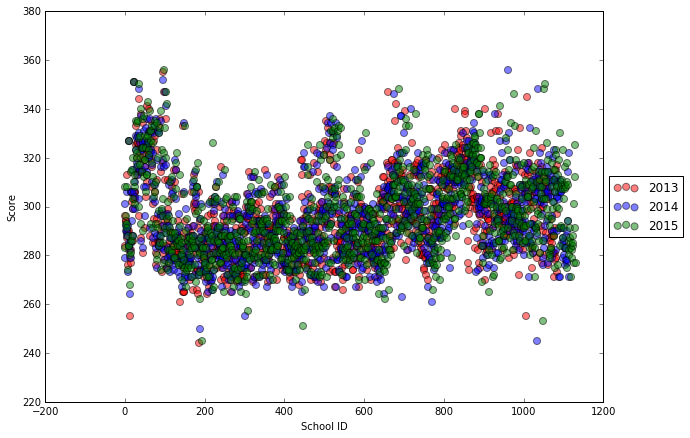

In [6]:
f = csv.DictReader(open("../Resources/ELA.csv", "rb"), delimiter=',')
y_2013 = []
y_2014 = []
y_2015 = []

for line in f:
    name  = line["School Name"]
    grade = line["Grade"]
    year  = line["Year"]
    score = line["Mean Scale Score"]
    if year == "2013" and grade == "All Grades":
        y_2013.append(score)
    elif year == "2014" and grade == "All Grades":
        y_2014.append(score)
    elif year == "2015" and grade == "All Grades":
        y_2015.append(score)

plt.figure(figsize=(10, 7))        
plt.scatter(range(len(y_2013)), y_2013, s=50, c='r', alpha=0.5, label="2013")
plt.scatter(range(len(y_2014)), y_2014, s=50, c='b', alpha=0.5, label="2014")
plt.scatter(range(len(y_2015)), y_2015, s=50, c='g', alpha=0.5, label="2015")
plt.xlabel("School ID")
plt.ylabel("Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Regression Model

In [7]:
def linear_regr(train, test):
    """
    Trains a regression model
    :param train: the train data
    :param test: the test data
    """
    train_x = numpy.array([[item[2] for item in train]]).astype(numpy.float).T
    train_y = numpy.array([[item[3] for item in train]]).astype(numpy.float).T
    
    test_x = numpy.array([[item[2] for item in test]]).astype(numpy.float).T
    test_y = numpy.array([[item[3] for item in test]]).astype(numpy.float).T
    
    scaler = preprocessing.StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
 
    regr = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regr.fit(train_x, train_y)
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean square error
    print("Residual sum of squares: %.2f" % numpy.mean((regr.predict(test_x) - test_y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(test_x, test_y))
    
    # Plot outputs
    plt.figure(figsize=(10, 7)) 
    plt.scatter(test_x, test_y,  color='black')
    plt.plot(test_x, regr.predict(test_x), color='blue', linewidth=3)

    plt.xlabel("N. Permits")
    plt.ylabel("Test Score")

    plt.show()

### Regression considering all Categories of Permit

In [8]:
# Regression for all permit categories

data = list(itertools.chain(*permiters_data.values()))

In [9]:
school_train = get_school_data(data, ["All Grades"], ["2013", "2014"])

In [10]:
school_test = get_school_data(data, ["All Grades"], ["2015"])

In [11]:
print "Number of train samples:", len(school_train)
print "Number of test samples:", len(school_test)

Number of train samples: 1852
Number of test samples: 929


('Coefficients: \n', array([[-0.00227565]]))
Residual sum of squares: 290.75
Variance score: -0.00


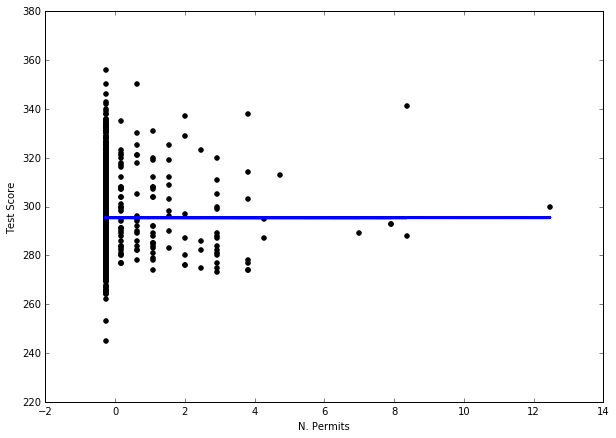

In [12]:
linear_regr(school_train, school_test)

### Regression for each Category of Permit

Permit type: FULL DEMOLITION
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[ 0.]]))
Residual sum of squares: 290.75
Variance score: -0.00


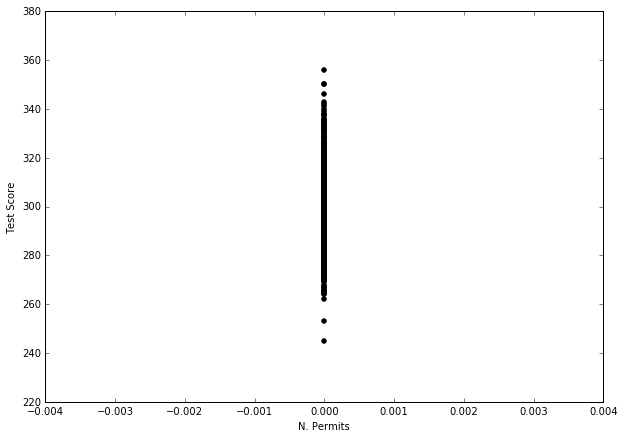

Permit type: FOUNDATION
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[ 0.]]))
Residual sum of squares: 290.75
Variance score: -0.00


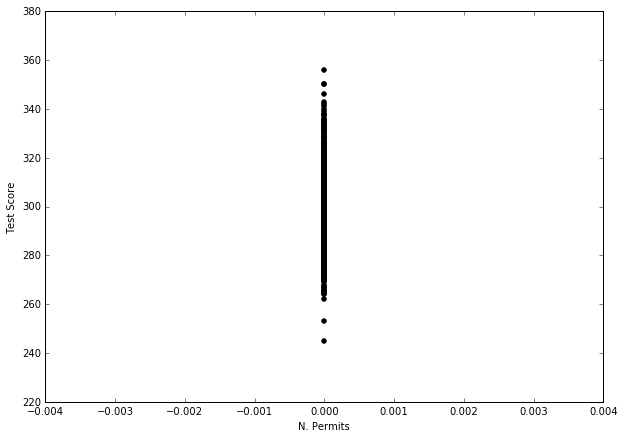

Permit type: NEW BUILDING
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[ 0.26344671]]))
Residual sum of squares: 290.77
Variance score: -0.00


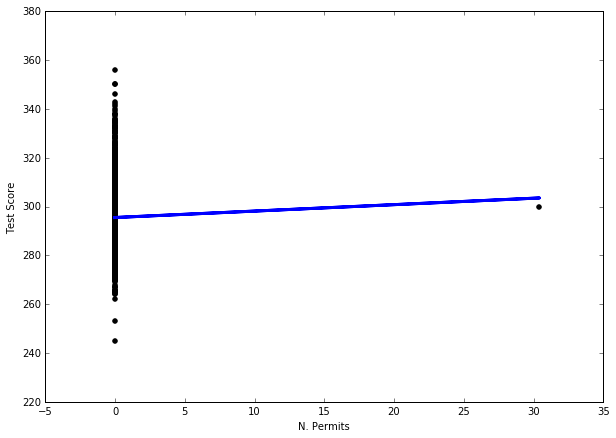

Permit type: ALTERATION
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[-0.11388472]]))
Residual sum of squares: 290.76
Variance score: -0.00


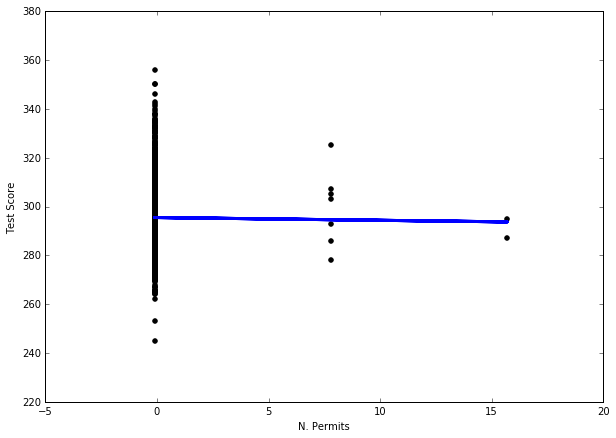

Permit type: SIGN
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[ 0.]]))
Residual sum of squares: 290.75
Variance score: -0.00


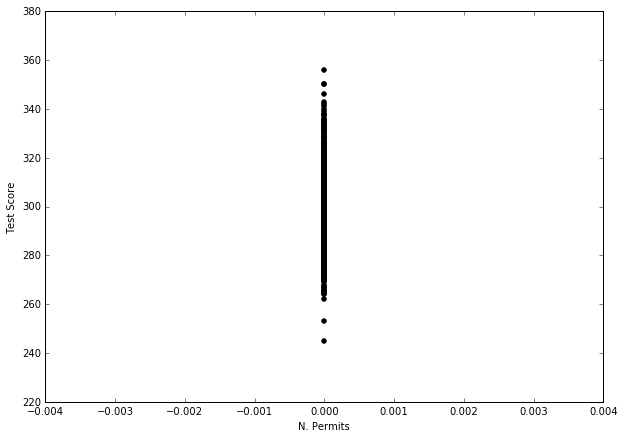

Permit type: EQUIPMENT
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[-0.25966162]]))
Residual sum of squares: 290.69
Variance score: -0.00


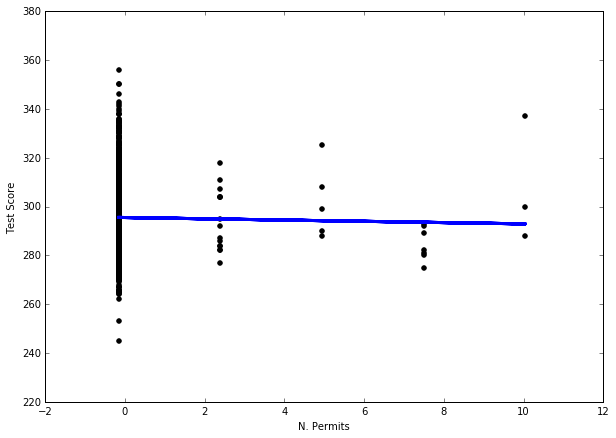

Permit type: PLUMBING
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[ 0.07646882]]))
Residual sum of squares: 290.74
Variance score: -0.00


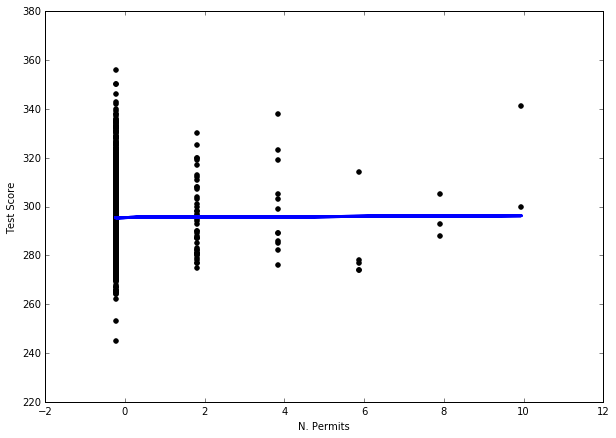

Permit type: EQUIPMENT WORK
Number of train samples: 1852
Number of test samples: 929
('Coefficients: \n', array([[ 0.04032339]]))
Residual sum of squares: 290.75
Variance score: -0.00


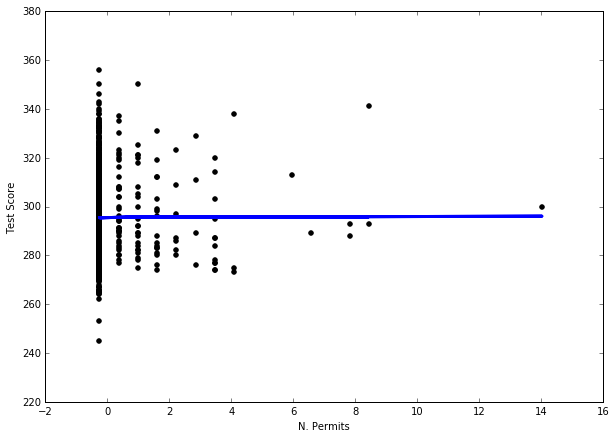

In [13]:
for key, value in permiters_data.iteritems():
    print "Permit type:", key
    school_train = get_school_data(value, ["All Grades"], ["2013", "2014"])
    school_test = get_school_data(value, ["All Grades"], ["2015"])
    print "Number of train samples:", len(school_train)
    print "Number of test samples:", len(school_test)
    linear_regr(school_train, school_test)
    